In [1]:
import dependency_installer

dependency_installer.main();

import xarray as xr
from data_hunter_era5 import DataRetriver
import matplotlib.pyplot as plt


%matplotlib inline
# dependency_installer.main()

Defaulting to user installation because normal site-packages is not writeable


In [2]:

def retrive_custom_data(startDate, endDate, properties, long_min, long_max, lat_min,lat_max):
    # [N,W,S,E]
    area = [lat_max, long_min, lat_min, long_max]
    return DataRetriver.retrive_data_xarray(startDate, endDate, properties, area)



In [3]:

def kelvin_to_celsius(ds):
    ds_arr = ds.mn2t - 273.15
    ds_arr.attrs['units'] = 'ºC'
    ds = xr.Dataset({"Near surface air temperature (C)" : ds_arr })
    return ds


In [4]:
# global observed data

global_observed_data = retrive_custom_data(
    startDate='2019-11-25',
    endDate='2019-11-28',
    properties= ['10m_u_component_of_wind', '10m_v_component_of_wind','2m_temperature','surface_pressure'],
    long_min = 43, 
    long_max = 46, 
    lat_min= 38.5,
    lat_max= 41, )

# global_observed_data[0]
# global_observed_data[0] = kelvin_to_celsius(global_observed_data[0])
longitude_value = 179.75
latitude_value = -89.75

localized_data = xr.merge(global_observed_data).sel(longitude=longitude_value, latitude=latitude_value, method='nearest')
localized_data = localized_data.drop_vars("longitude")
localized_data = localized_data.drop_vars("latitude")
localized_data
# df = localized_data.to_dataframe()
# df
# global_observed_data[0].loc((0, "-180", "-90"))

<xarray.Dataset>
Dimensions:  (time: 96)
Coordinates:
  * time     (time) datetime64[ns] 2019-11-25 ... 2019-11-28T23:00:00
Data variables:
    u10      (time) float32 -0.7359 -0.7136 -0.6932 ... -0.0914 -0.2889 -0.2117
    v10      (time) float32 0.0002836 0.02635 0.08591 ... 0.4523 0.9375 0.3981
    t2m      (time) float32 269.1 269.2 268.5 268.9 ... 275.7 275.2 273.9 274.2
    sp       (time) float32 8.188e+04 8.183e+04 8.183e+04 ... 8.17e+04 8.17e+04
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-09 20:38:44 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [5]:
def filter_with_coordinates(ds, long_min, long_max, lat_min, lat_max):
    
    ds_filtered = ds.sel(longitude=slice(long_min, long_max), latitude=slice(lat_max,lat_min))
    return ds_filtered


In [6]:
# def plot_hourly_temperature(ds, day_hour):
    
#     ds_timed = ds.isel(time=day_hour)
#     ds_timed.to_array().plot(cmap='jet')

# plot_hourly_temperature(global_observed_data[0], 23)

/Users/vardanmelkonyan/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


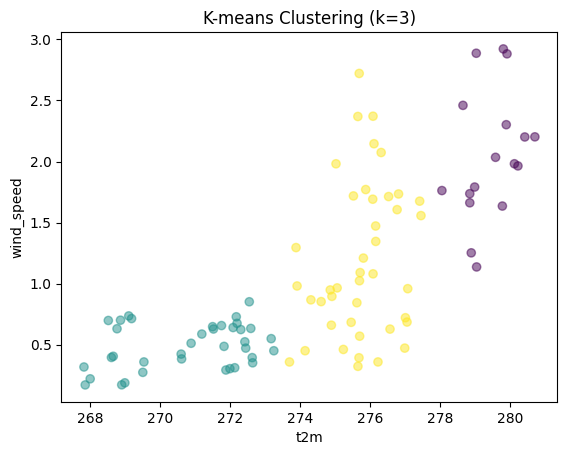

In [10]:
from sklearn.cluster import KMeans
import numpy as np
# Assuming ds is your xarray.Dataset

# Extract the relevant variables for clustering
localized_data['wind_speed'] = np.sqrt(localized_data['u10']**2 + localized_data['v10']**2)
data_for_clustering = localized_data[['t2m', 'wind_speed']]



# Convert xarray.Dataset to numpy array
data_array = data_for_clustering.to_array().values.T

# Reshape the array to 2D (time x features)
data_array_2d = data_array.reshape(data_array.shape[0], -1)

# Specify the number of clusters (k)
k = 3

# Perform K-means clustering
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(data_array_2d)

# Add cluster labels to the dataset
localized_data['cluster_labels'] = xr.DataArray(clusters, dims=['time'])


# Visualize the clusters (using only two features for simplicity)
ax = plt.subplots()
plt.scatter(localized_data['t2m'], localized_data['wind_speed'], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('t2m')
plt.ylabel('wind_speed')
plt.title(f'K-means Clustering (k={k})')
# ax.axline((0, 0), slope=0, color="red")
# ax.axline((0, 0), slope=10000000, color="blue") # high sloping is just tricky way of drawing vertical axis
plt.show()

#fig, ax = plt.subplots()

#import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
# Assuming you have 't2m', 'v10', and 'clusters' columns in localized_data DataFrame
# Create a figure and a 3D axis
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
# Scatter plot in 3D
#ax.scatter(localized_data['v10'], localized_data['t2m'], localized_data['t2m'], c=clusters, cmap='viridis', alpha=0.5)
# Set labels
#ax.set_xlabel('v10')
#ax.set_ylabel('t2m')
#ax.set_zlabel('u10')  
# Set title
#ax.set_title(f'K-means Clustering (k={k})')

# Draw red and blue lines (assuming you wanted to draw lines)
#ax.axline((0, 0), slope=0, color="red")
#ax.axline((0, 0), slope=10000000, color="blue")  # high sloping is just a tricky way of drawing a vertical axis

# Show the plot
#plt.show()


#Cold and Calm Cluster:

#Cluster with low temperatures and relatively low wind speeds.
#This cluster may represent cold, calm weather conditions, possibly associated with winter or specific local climate features.
#Moderate Temperature and Moderate Wind Cluster:

#Cluster with moderate temperatures and moderate wind speeds.
#This cluster might indicate typical or transitional weather conditions with moderate temperatures and wind speeds.
#Warm and Windy Cluster:

#Cluster with higher temperatures and higher wind speeds.
#This cluster could represent warm, windy conditions, possibly associated with summer or specific regional climatic patterns.

2019 11 25


2023-12-10 15:13:32,150 INFO Welcome to the CDS
2023-12-10 15:13:32,151 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-12-10 15:13:32,297 INFO Request is completed
2023-12-10 15:13:32,298 INFO Downloading https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data3/adaptor.mars.internal-1702202887.2669892-9174-10-c9764741-5abf-4887-bc93-0848aa62f006.nc to ./NetCDF_data/era5/10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_surface_pressure_soil_temperature_level_1_/41_43_38.5_46_/2019_11_25.nc (35.8K)
2023-12-10 15:13:32,711 INFO Download rate 86.7K/s
2023-12-10 15:13:32,875 INFO Welcome to the CDS
2023-12-10 15:13:32,876 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


2019 11 26


2023-12-10 15:13:33,027 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data9/adaptor.mars.internal-1702202895.946849-8095-12-cbb0c39d-0dfb-469b-a30e-802f9049bc7b.nc to ./NetCDF_data/era5/10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_surface_pressure_soil_temperature_level_1_/41_43_38.5_46_/2019_11_26.nc (35.8K)
2023-12-10 15:13:33,540 INFO Download rate 70K/s
2023-12-10 15:13:33,703 INFO Welcome to the CDS
2023-12-10 15:13:33,704 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


2019 11 27


2023-12-10 15:13:33,843 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data2/adaptor.mars.internal-1702202905.7507193-21335-5-d309980b-f2b2-4e7d-86b6-612a92bec111.nc to ./NetCDF_data/era5/10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_surface_pressure_soil_temperature_level_1_/41_43_38.5_46_/2019_11_27.nc (35.8K)
2023-12-10 15:13:34,313 INFO Download rate 76.3K/s
2023-12-10 15:13:34,491 INFO Welcome to the CDS
2023-12-10 15:13:34,492 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


2019 11 28


2023-12-10 15:13:34,640 INFO Downloading https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data6/adaptor.mars.internal-1702202914.368758-9303-16-6034a62e-2f22-455e-b456-534772a49b9b.nc to ./NetCDF_data/era5/10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_surface_pressure_soil_temperature_level_1_/41_43_38.5_46_/2019_11_28.nc (35.8K)
2023-12-10 15:13:34,811 INFO Download rate 209.3K/s


./NetCDF_data/era5/10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_surface_pressure_soil_temperature_level_1_/41_43_38.5_46_/2019_11_25.nc
./NetCDF_data/era5/10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_surface_pressure_soil_temperature_level_1_/41_43_38.5_46_/2019_11_26.nc
./NetCDF_data/era5/10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_surface_pressure_soil_temperature_level_1_/41_43_38.5_46_/2019_11_27.nc
./NetCDF_data/era5/10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_surface_pressure_soil_temperature_level_1_/41_43_38.5_46_/2019_11_28.nc
Explained Variance Ratio: [0.4864879  0.31171843 0.12524253 0.07655116]
Cumulative Explained Variance: [0.4864879  0.7982063  0.92344886 1.        ]


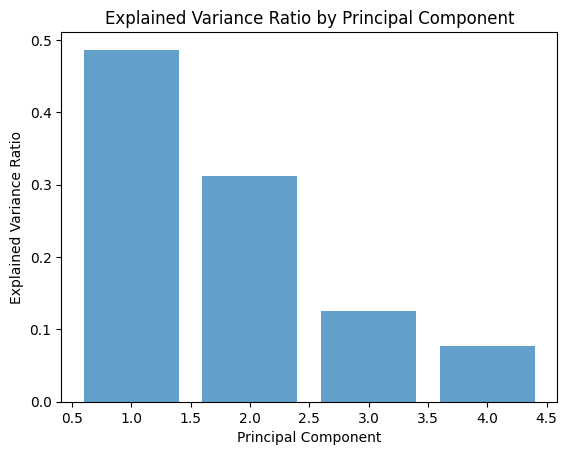

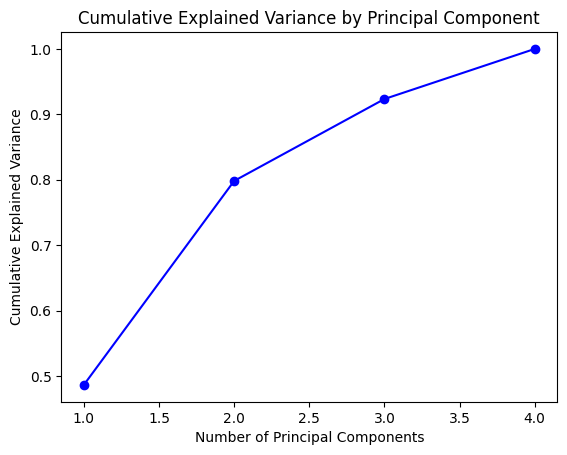

In [11]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd

# Assuming 'global_observed_data[0]' is your dataset
# Extract the data for PCA


# global observed data

pca_observed_Data = retrive_custom_data(
    startDate='2019-11-25',
    endDate='2019-11-28',
    properties= ['10m_u_component_of_wind', '10m_v_component_of_wind','2m_temperature','surface_pressure', 'soil_temperature_level_1'],
    long_min = 43, 
    long_max = 46, 
    lat_min= 38.5,
    lat_max= 41, )

# print(pca_observed_Data)


data_for_pca = xr.merge(pca_observed_Data).to_dataframe()

# Select relevant variables for PCA (adjust these based on your specific data)
data_for_pca['wind_speed'] = np.sqrt(data_for_pca['u10']**2 + data_for_pca['v10']**2)

selected_variables = ['t2m', 'sp', 'wind_speed', 'stl1']
data_for_pca = data_for_pca[selected_variables]


# Standardize the data (optional but recommended for PCA)
standardized_data = (data_for_pca - data_for_pca.mean()) / data_for_pca.std()

# Initialize PCA with the number of components you want to retain
n_components = len(data_for_pca.columns)  # Adjust the number of components based on your requirements
pca = PCA(n_components=n_components)

# Fit and transform the data
pca_result = pca.fit_transform(standardized_data)

# Create a DataFrame to store the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])

# Add the time index back to the PCA DataFrame
pca_df['time'] = data_for_pca.index

# Visualize the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print('Explained Variance Ratio:', explained_variance_ratio)

# Visualize the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print('Cumulative Explained Variance:', cumulative_explained_variance)

import matplotlib.pyplot as plt

# Plot the explained variance ratio
plt.bar(range(1, n_components + 1), explained_variance_ratio, alpha=0.7, align='center')
plt.title('Explained Variance Ratio by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Plot the cumulative explained variance
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='-', color='b')
plt.title('Cumulative Explained Variance by Principal Component')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [58]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ParameterEstimator, StructureEstimator
from pgmpy.inference import VariableElimination
import pandas as pd


cni_observed_Data = retrive_custom_data(
    startDate='2019-11-25',
    endDate='2019-11-28',
    properties= ['10m_u_component_of_wind', '10m_v_component_of_wind','2m_temperature','surface_pressure', 'soil_temperature_level_1'],
    long_min = 43, 
    long_max = 46, 
    lat_min= 38.5,
    lat_max= 41)

# Assuming 'global_observed_data[0]' is your dataset
# Extract the data for causal network inference



data_for_causal_network = xr.merge(cni_observed_Data).sel(longitude=longitude_value, latitude=latitude_value, method='nearest').to_dataframe()

# Drop the 'time' column as it is not needed for causal inference
# data_for_causal_network = data_for_causal_network.drop(columns=['time'])

# Define the structure of the Bayesian Network
# You need to specify the causal relationships based on your domain knowledge
# Here, I'm assuming a simple structure for demonstration purposes
edges = [('u10', 't2m'), ('v10', 't2m')]
model = BayesianNetwork(edges)


# Estimate the parameters of the model
model.fit(data_for_causal_network)
inference = VariableElimination(model)
predicted_t2m = inference.map_query(variables=['t2m'], evidence={'u10': 2, 'v10': 2})
print('Predicted t2m:', predicted_t2m)

./NetCDF_data/era5/10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_surface_pressure_soil_temperature_level_1_/41_43_38.5_46_/2019_11_25.nc
./NetCDF_data/era5/10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_surface_pressure_soil_temperature_level_1_/41_43_38.5_46_/2019_11_26.nc
./NetCDF_data/era5/10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_surface_pressure_soil_temperature_level_1_/41_43_38.5_46_/2019_11_27.nc
./NetCDF_data/era5/10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_surface_pressure_soil_temperature_level_1_/41_43_38.5_46_/2019_11_28.nc


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Predicted t2m: {'t2m': 267.83435}


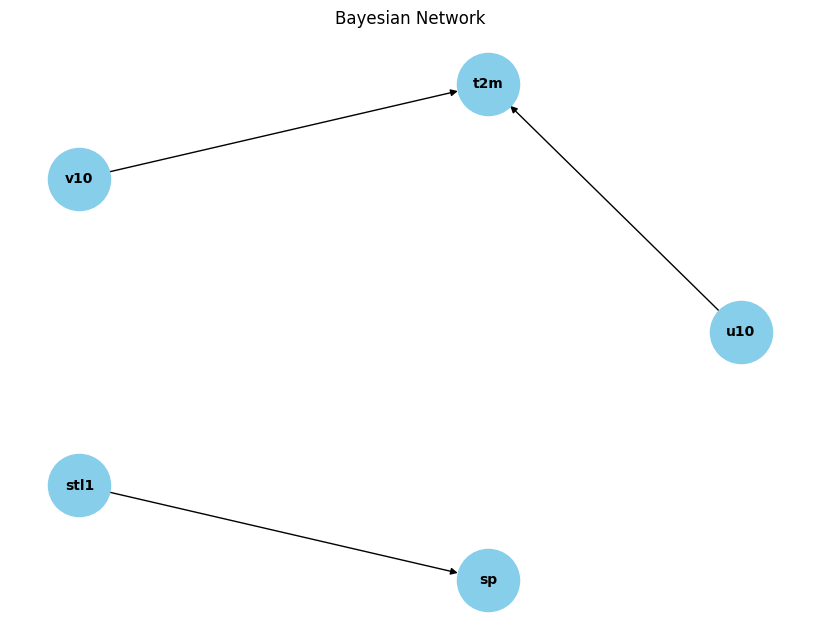

In [60]:
import networkx as nx

# Visualize the model (optional)

pos = nx.circular_layout(model)
plt.figure(figsize=(8, 6))
nx.draw(model, pos=pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, font_color="black", font_weight="bold")
plt.title("Bayesian Network")
plt.show()

In [5]:
import statsmodels.api as sm
import pandas as pd


regression_observed_Data = retrive_custom_data(
    startDate='2019-11-25',
    endDate='2019-11-28',
    properties= ['10m_u_component_of_wind', '10m_v_component_of_wind','2m_temperature','surface_pressure', 'soil_temperature_level_1'],
    long_min = 43, 
    long_max = 46, 
    lat_min= 38.5,
    lat_max= 41)

# Extract the data for multivariate regression

data_for_regression =xr.merge(regression_observed_Data).sel(longitude=longitude_value, latitude=latitude_value, method='nearest').to_dataframe()

# Drop the 'time' column as it is not needed for regression
# data_for_regression = data_for_regression.drop(columns=['time'])

# Define the target variable and independent variables
target_variable = 't2m'
independent_variables = ['u10', 'v10', 'sp', 'stl1']  # Adjust based on your specific variables

# Extract the target and independent variables from the DataFrame
y = data_for_regression[target_variable]
X = data_for_regression[independent_variables]

# Add a constant term to the independent variables matrix (required for statsmodels)
X = sm.add_constant(X)

# Fit the multivariate regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    t2m   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     68.93
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.01e-26
Time:                        13:17:31   Log-Likelihood:                -188.56
No. Observations:                  96   AIC:                             387.1
Df Residuals:                      91   BIC:                             399.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        921.1091    248.618      3.705      0.0